# Digit Recognizer Dataset Introduction
###It contains the following info:
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

In [1]:
!pip3 install mnist

  Using cached mnist-0.2.2-py2.py3-none-any.whl (3.5 kB)


In [2]:
import torch                        # The core package of Torch
import torch.nn as nn               # The nn package is used for building neural networks
import torch.nn.functional as F     # Contains all the functions in the torch.nn library

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data
As input information I have two CSV files:

#### **train.csv** 
    contains information about 42 000 (60% of the whole MNIST dataset) gray-scale images of hand-drawn digits (from 0 to 9).
    First column is the digit. The rest 784 columns represent pixels of hand-drawn digit (each image has 28 x 28 pixels shape). The value of each pixel-column is an intager between 0 and 255 - represent darkness or lightness of the given pixel.
#### **test.csv**
    contains information about 28 000 gray-scale images of hand-drawn digits (from 0 to 9). Doesn't contain labels.

In [3]:
import mnist as MNIST
import numpy as np

train_images = MNIST.train_images()
train_labels = MNIST.train_labels()
test_images = MNIST.test_images()
test_labels = MNIST.test_labels()

print(train_images.shape, test_images.shape)
print(train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


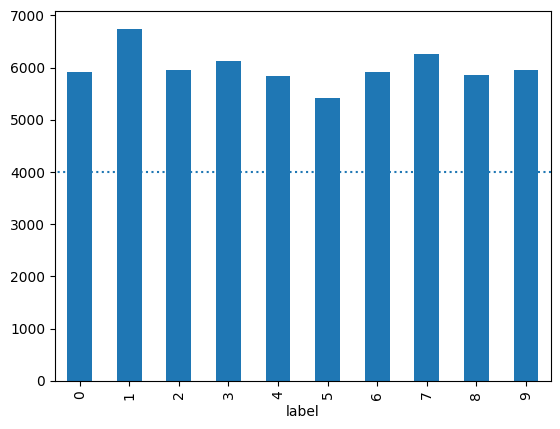

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

train_data_label = pd.DataFrame(train_labels, columns=["label"])

label_counts  = train_data_label["label"].value_counts().sort_index()
label_counts.plot.bar()
plt.hlines(xmin = -1, xmax = 10, y = 4000, linestyles='dotted')


Split labels and features of training dataset and convert to numpy array:

In [5]:
train_all_numpy = train_images
train_all_label_numpy = train_labels
test_numpy = test_images

visualize some train examples with it's labels:

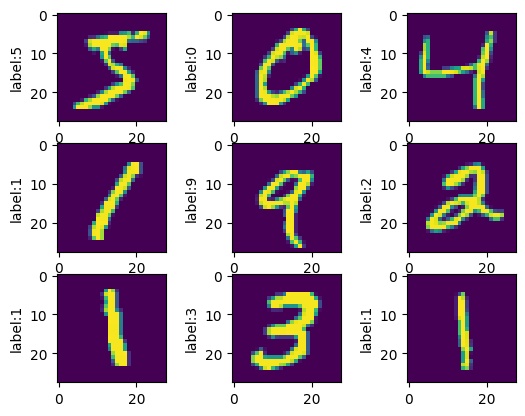

In [6]:
def plot_img(data, label):
    fig, axs = plt.subplots(3, 3) # 9 images
    k = 0
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(data[k].astype('uint8').reshape(28, 28))   # plot image
            axs[i, j].set_ylabel("label:" + str(label[k].item()))       # print label
            k +=1
plot_img(train_all_numpy, train_all_label_numpy)

### Train and validation
check model on unseen data before submitting it.
Since we don't have labels in test dataset, we will randomly split my training data on training and validation datasets in proportion 8:2.
To do so, we will be using train_test_split function from sklearn module:

In [7]:
from sklearn.model_selection import train_test_split

# split train on train and validation
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.2)

print("train.x ->", train.shape)
print("train.y ->", train_label.shape)
print("valid.x ->", validation.shape)
print("valid.y ->", validation_label.shape)

train.x -> (48000, 28, 28)
train.y -> (48000,)
valid.x -> (12000, 28, 28)
valid.y -> (12000,)


Check if both datasets represent all classes in fair proportion:

<BarContainer object of 10 artists>

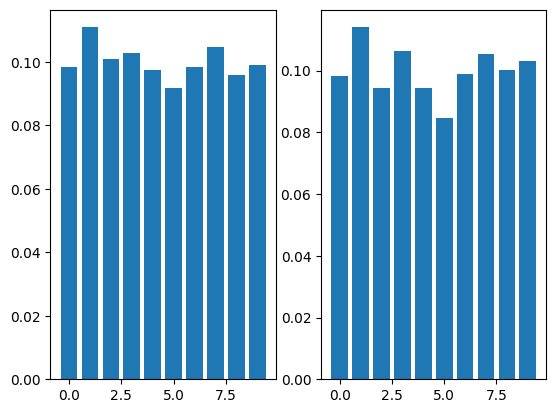

In [12]:
import numpy as np

unique, counts_train = np.unique(train_label, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique, counts_train/len(train_label))
unique, counts_val = np.unique(validation_label, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique, counts_val/len(validation_label))
#print (np.asarray((unique, counts_train/len(train_label), counts_val/len(validation_label))).T)

### Tensors
Tensor is a multi-dimensional matrix containing elements of a single data type. To use PyTorch, we need to covert our data to tensors.

In [13]:
import torch

train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

### FNN
Let's build the model

In [20]:
from torch import nn

# nn.Module - Base class for all neural network modules.
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        # 784 inputs, connects to hidden layer with 600 nodes
        self.fc1 = nn.Linear(in_features=784, out_features=600)
        # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500)
        # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250)
        # connection between the last hidden layer
        # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)

    def forward(self, x):
        x = x.view(-1,784) # Put all the entries of the image in the vector
        x = nn.functional.relu(self.fc1(x)) # Input x into first layer and apply a ReLU
                                            # to the nodes in this layer
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Layers
    A fully connected neural network consists of a series of fully connected layers.
    The first layer takes the 784 (28 x 28) input pixels and connects to the first 600 node hidden layer. Then we have 600 to 500 hidden layer, 500 to 250 hidden layer and in the end the connection between the last hidden layer and the output layer (with 10 nodes).

- input: 784 (image shape)
- 3 hidden layers (600, 500, 250 nodes)
- output: 10 neurons for each possible class

    I use nn.Linear to constructs a fully connected layer. The first argument is the number of nodes in layer l and the next argument is the number of nodes in layer l+1.

### Forward method
    First, I need to reshape tensor x, so I use the view function for it.
    Second, input data x into the first fully connected layer (self.fc1(x)) and then apply a ReLU activation to the nodes in this layer using. Because of the hierarchical nature of this network, we replace x at each stage, feeding it into the next layer.

    We do this through our three fully connected layers, except for the last one.
    As activation function, I am using ReLU (The Rectified Linear Unit). It gives an output 0 if x is negative and x otherwise. The purpose of the activation function is to introduce non-linearity into the network (non-linear means that the output can not be reproduced from a linear combination of the inputs). To do it in code, I am using F.relu - applies the rectified linear unit function element-wise.



### Accuracy
Before start the training process, let's define an accuracy function.
##### Accuracy - fraction of the time classifier is correct.

In [21]:
import torch

def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

### Training function

#### Training process:
1.   Do a forward pass
2.   Calculate loss function
3.   Calculate the gradients
4.   Change the weights based on gradients

The entire training of the network is based on minimizing the loss function. An optimizer determines, based on the loss function, how each parameter should change.
The optimizer solves the credit assignment problem: how do we assign credit to the parameters when the network performs poorly?

In [35]:
def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies, train_losses = [], []

    # set the train mode
    model.train()

    # loop over training dataset multiple times
    for epoch in range(epochs):

        train_loss = 0
        train_accuracy = 0
        num_batch = 0

        # iterate over all batches
        for data, labels in dataloader:

            # zero the parameters gradient to not accumulate gradients from previous iteration
            optimizer.zero_grad()

            # put data into the model
            predictions = model(data)

            # calculate loss
            loss = criterion(predictions, labels)

            # calculate accuracy
            accuracy = get_accuracy(predictions, labels)

            # compute gradients
            loss.backward()

            # change the weights
            optimizer.step()

            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accuracy

        epoch_accuracy = train_accuracy/num_batch
        epoch_loss = train_loss/num_batch
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)

        if epoch%10 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, epochs),
                  "Training Loss: {:.4f} ".format(epoch_loss),
                  "Training accuracy: {:.4f}".format(epoch_accuracy))

    return train_accuracies, train_losses

In [23]:
import torch

torch.manual_seed(0) # set seed to make results reproducible

batch_size = 128 # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


epochs = 40 # set number of epohs

net = FNet() # initialize network
criterion = nn.CrossEntropyLoss() # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

# start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3000  Training accuracy: 91.3973
Epoch: 2/40  Training Loss: 0.0919  Training accuracy: 97.0889
Epoch: 3/40  Training Loss: 0.0548  Training accuracy: 98.2266
Epoch: 4/40  Training Loss: 0.0363  Training accuracy: 98.7999
Epoch: 5/40  Training Loss: 0.0331  Training accuracy: 98.9365
Epoch: 6/40  Training Loss: 0.0281  Training accuracy: 99.0316
Epoch: 7/40  Training Loss: 0.0184  Training accuracy: 99.4772
Epoch: 8/40  Training Loss: 0.0242  Training accuracy: 99.2336
Epoch: 9/40  Training Loss: 0.0257  Training accuracy: 99.1148
Epoch: 10/40  Training Loss: 0.0177  Training accuracy: 99.4534
Epoch: 11/40  Training Loss: 0.0251  Training accuracy: 99.2336
Epoch: 12/40  Training Loss: 0.0142  Training accuracy: 99.5277
Epoch: 13/40  Training Loss: 0.0179  Training accuracy: 99.4148
Epoch: 14/40  Training Loss: 0.0167  Training accuracy: 99.4980
Epoch: 15/40  Training Loss: 0.0157  Training accuracy: 99.4831
Epoch: 16/40  Training Loss: 0.0231  Training acc

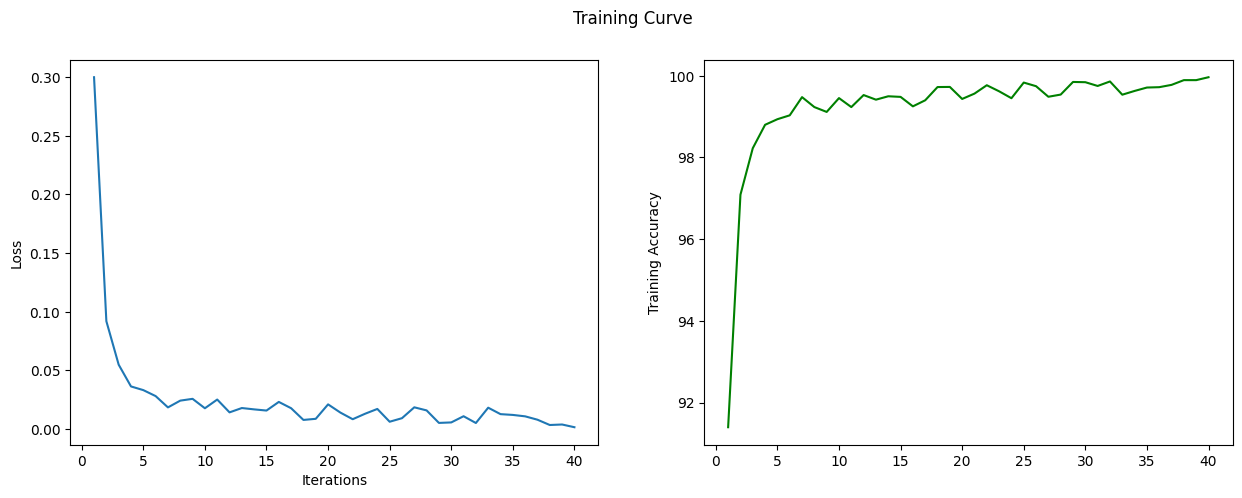

In [26]:
import matplotlib.pyplot as plt

def train_curves(epochs, train_losses, train_accuracies):
    iters = range(1, epochs+1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharex=True)
    fig.suptitle('Training Curve')
    ax1.plot(iters, train_losses)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax2.plot(iters, train_accuracies, color = 'g')
    ax2.set_ylabel("Training Accuracy")
    plt.show()

train_curves(epochs, train_losses, train_accuracies)

In [32]:
from sklearn.metrics import confusion_matrix

# set net in test (evaluation) mode
net.eval()

# get predictions
val_predictions = net(validation_tensor)
val_loss = criterion(val_predictions, validation_label)
val_accuracy = get_accuracy(val_predictions, validation_label)

print("Loss: ", str(val_loss.item()), "Accuracy: ", str(val_accuracy))

# to get class with the maximum score as prediction
_, val_predicted = torch.max(val_predictions.data, 1)

# confusion matrix
confusion_matrix(validation_label, val_predicted)

Loss:  0.1649002730846405 Accuracy:  97.80952453613281


array([[815,   0,   1,   0,   3,   1,   3,   0,   1,   2],
       [  0, 951,   2,   0,   2,   0,   0,   3,   0,   0],
       [  2,   0, 777,   0,   3,   0,   0,   6,   3,   1],
       [  1,   1,   7, 852,   0,  21,   0,   1,   8,   2],
       [  0,   2,   1,   0, 772,   0,   1,   3,   2,  13],
       [  1,   0,   1,   3,   0, 700,   3,   0,   3,   1],
       [  2,   0,   1,   0,   0,   3, 824,   0,   1,   0],
       [  0,   3,   3,   1,   2,   0,   1, 866,   2,   7],
       [  1,   2,   5,   4,   0,   6,   4,   1, 814,   6],
       [  1,   1,   1,   0,   6,   4,   0,   6,   2, 845]])

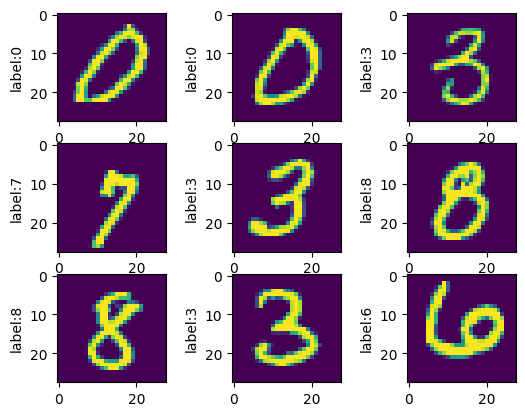

In [33]:
plot_img(validation, val_predicted)

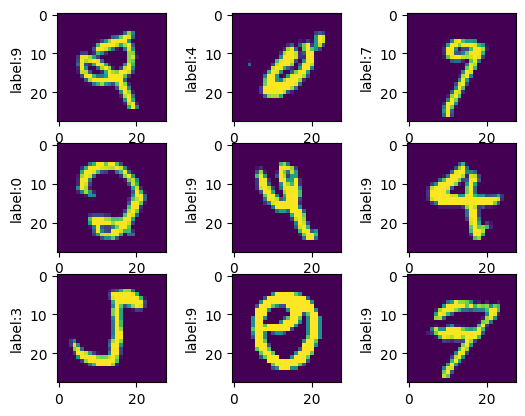

In [34]:
# wrong predicted

val_wrong = validation[validation_label != val_predicted]
val_lab_wrong = val_predicted[validation_label != val_predicted]

plot_img(val_wrong, val_lab_wrong)

In [36]:
import torch

torch.manual_seed(0) # set seed to make results reproducible

batch_size = 128 # Set the batch_size
train_all_dataset = torch.utils.data.TensorDataset(train_all_tensor, train_all_label_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

epochs = 40 # set number of epochs

net = FNet() # initialize network
criterion = nn.CrossEntropyLoss() # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

# start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3000  Training accuracy: 91.3973
Epoch: 11/40  Training Loss: 0.0251  Training accuracy: 99.2336
Epoch: 21/40  Training Loss: 0.0140  Training accuracy: 99.5633
Epoch: 31/40  Training Loss: 0.0109  Training accuracy: 99.7505


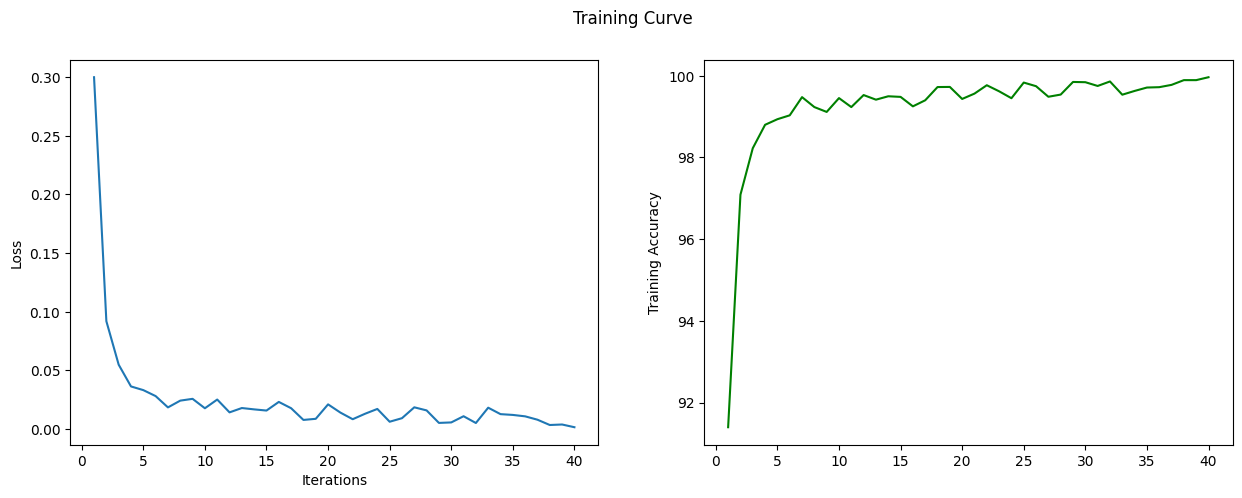

In [37]:
train_curves(epochs, train_losses, train_accuracies)

In [38]:
import torch

# set net in test (evaluation) mode
net.eval()

# get predictions for test data
test_predictions = net(test_tensor)

# to get class with the maximum score as prediction
_, test_predicted = torch.max(test_predictions.data,1)

# Save results in the required format
output = pd.DataFrame({
    'ImageId': test.index + 1, 
    'Label': test_predicted
})
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
